In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
from cmocean import cm
import cartopy.crs as ccrs
img = plt.imread('/home/jan/Data/cartopy_images/BlueMarble_TOPO_010_JAN.png')
from xmovie import Movie



We use Optimum Interpolation Sea Surface Temperature (OISST) v2.1 data provided by NOAA ([link](https://www.ncdc.noaa.gov/oisst/data-access)) for this example.  

The background image is taken from the NASA visible earth collection Blue Marble ([link](https://visibleearth.nasa.gov/collection/1484/blue-marble)) 

First, we need to construct a list with the file names that we want to access. In this case, we want to plot the first month of 2020 but it's easy to extend that to the full year by changing the range of the `for` loop to `range(1, 13)`.

In [2]:
file_base = "https://www.ncei.noaa.gov/thredds/dodsC/OisstBase/NetCDF/V2.1/AVHRR/2020"
file_list = []

len_mon = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
for m in range(1, 2):
    l_mon = len_mon[m - 1]
    m2 = "%02d" % m
    file_ext = file_base + m2 + "/oisst-avhrr-v02r01.2020"
    for d in range(1, l_mon + 1):
        d2 = "%02d" % d
        file_list.append(file_ext + str(m2) + str(d2) + ".nc")

We use `xarray` to open all OPENDAP links in `file_list` to have them in one dataset.

In [3]:
ds = xr.open_mfdataset(file_list)

We need to define a new class for the projection to change the `threshold` value in order to draw smooth lines with `plot`

In [4]:
class LowerThresholdNearsidePerspective(ccrs.NearsidePerspective):

    @property
    def threshold(self):
        return 1000

### Now the animation

In [5]:
# First, we define some levels for the colors we want to use in order to create a discrete (and not continuous)
# colormap
levs = np.arange(-2, 32, 1)
norm = colors.BoundaryNorm(boundaries=levs, ncolors=256)
# Now we define how long the animation should be
len_anim = len(ds.time)

# Now define a range of central longitudes (during the animation, the central longitude will vary over this range)
cen_lon = np.linspace(-10.0, 50.0, len_anim)
cen_lat = np.ones(len_anim) * (-25)

# Define the range of satellite heights for a zoom effect
min_height = 10000000
max_height = 35785831
# We will use a cosine for the zoom, so it looks smooth
sat_height = (np.cos(np.linspace(0, np.pi, len_anim)) + 2) * np.linspace(max_height/3, min_height, len_anim)

# This ratio (some form of assessing how far we zoomed in) is used to set the axis limits for the y axis
rat_height = sat_height / max_height
ylim_0 = -5500000
ylim_1 = 5500000

# Then we set up the figure
fig = plt.figure(figsize=(8,4), dpi=50) # set `dpi` higher for higher quality saved animations in the end

# And create a function that plots the figures (frames) of the animation
def plot_frame(data, fig, tt):
    # We set up the projection to be used
    m1 = fig.add_subplot(1, 1, 1, projection=LowerThresholdNearsidePerspective(central_longitude=cen_lon[tt],
                                                                           central_latitude=cen_lat[tt],
                                                                           satellite_height=sat_height[tt],
                                                                           globe=None))
    # Now we display the background image
    # You can lower the value of `regrid_shape` to make the plotting faster, however this has negative effects
    # on the quality of the displayed background image
    m1.imshow(img, origin='upper', transform=ccrs.PlateCarree(),
              interpolation='spline36', regrid_shape=400, zorder=1)
    # And plot the SST data
    map1 = m1.pcolormesh(data.lon, data.lat, data.sst.isel(time=tt).squeeze(),
                  cmap=cm.thermal, norm=norm, transform=ccrs.PlateCarree(), zorder=2)
    # We add a colorbar and its label
    c = plt.colorbar(map1, pad=0.04, shrink=0.4, orientation='horizontal')
    c.ax.set_ylabel('$^{\circ}C$');
    # and a title
    m1.set_title("OISST at " + str(data.time.isel(time=tt).values)[0:10]);
    # Now we plot a line into the map (this could be the region you are interested in)
    line1 = m1.plot([30, 70, 70, 30, 30],
                    [-35, -35, -50, -50, -35],
                    linewidth=2, color='gold', transform=ccrs.PlateCarree(), zorder=3)
    # set the latitude limits of the plot. we do that in projection coordinates (m)
    # because there are some problems when using latitude
    ylim_low = ylim_0 * rat_height[tt]
    ylim_high = ylim_1 * rat_height[tt]
    m1.set_ylim(ylim_low, ylim_high)
    fig.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.9)
    return None, None
    
# And finally, we create the animation
mov_custom = Movie(ds, plot_frame, input_check=False)

<Figure size 400x200 with 0 Axes>

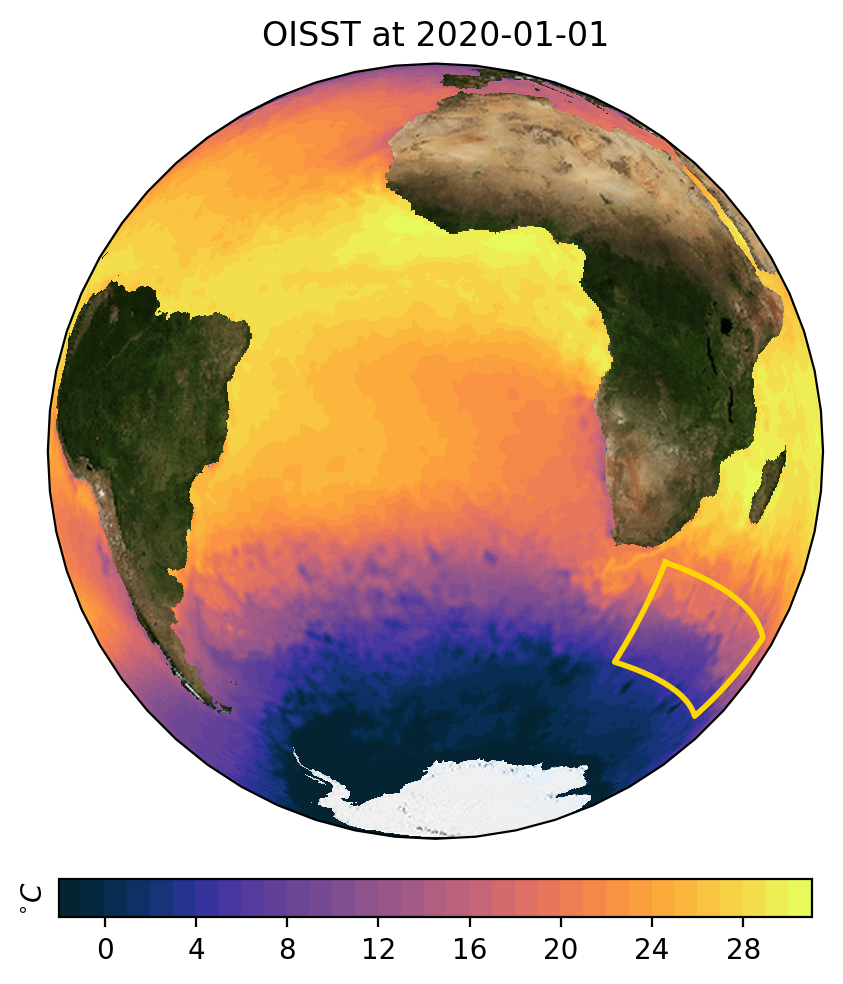

In [6]:
mov_custom.preview(0)

In [7]:
mov_custom.save('movie_custom.gif', progress=True, remove_movie=False, framerate=10, overwrite_existing=True)

  0%|          | 0/31 [00:00<?, ?it/s]

Movie created at movie_custom.mp4
GIF created at movie_custom.gif
